In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: GeForce RTX 2080 Ti


In [3]:
torch.cuda.get_device_properties(device).total_memory

11523260416

In [4]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r"http\S+", "", text)
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text=text.replace("#","")

    return text

In [5]:
 # Load data and set labels

data = pd.read_csv('/home/nazaninjafar/ds4cg2020/bert-covid/data/alldata2.tsv')
# data=data.append(test_data)


In [6]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y,stratify = y, test_size=0.1, random_state=42)
# train_idx, test_idx, y_train, y_test= train_test_split(indices, y,stratify = y, test_size=0.1, random_state=42)

In [7]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  nhl teams can't control the seasonal flu that runs through their dressing rooms every season, and now they think they can control the coronavirus? #nhl #covid19
Processed:  nhl teams can't control the seasonal flu that runs through their dressing rooms every season, and now they think they can control the coronavirus? nhl covid19


In [8]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Create a function to tokenize a set of texts
def preprocessing_for_ctbert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [9]:
# !pip install transformers

In [10]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  317


In [11]:
# encoded_tweets

In [12]:
# Specify `MAX_LEN`
MAX_LEN = 160

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_ctbert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_ctbert(X_train)
val_inputs, val_masks = preprocessing_for_ctbert(X_val)

Original:  nhl teams can't control the seasonal flu that runs through their dressing rooms every season, and now they think they can control the coronavirus? #nhl #covid19
Token IDs:  [101, 7097, 2780, 2064, 1005, 1056, 2491, 1996, 12348, 19857, 2008, 3216, 2083, 2037, 11225, 4734, 2296, 2161, 1010, 1998, 2085, 2027, 2228, 2027, 2064, 2491, 1996, 21887, 23350, 1029, 7097, 2522, 17258, 16147, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [13]:
train_inputs

tensor([[  101,  2115, 19857,  ...,     0,     0,     0],
        [  101, 15624,  1010,  ...,     0,     0,     0],
        [  101,  2079,  2017,  ...,     0,     0,     0],
        ...,
        [  101, 10090,  4615,  ...,     0,     0,     0],
        [  101, 21887, 23350,  ...,     0,     0,     0],
        [  101,  2151, 16270,  ...,     0,     0,     0]])

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [15]:
# %%time
# import torch
import torch.nn as nn
# model = AutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert")

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
#         print("input_ids",input_ids.size())
#         print("attention_mask",attention_mask.size())
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [16]:
learningrate=1e-5

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4,lr=learningrate):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=learningrate,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [18]:
import random
import time
import torch.nn as nn
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} |{'Train Acc':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()
#             print('b_input_ids',b_input_ids.size())
#             print('b_attn_mask',b_attn_mask.size())
            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy,_ = evaluate(model, val_dataloader)
            _,train_accuracy,_=evaluate(model,train_dataloader)
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {train_accuracy:^9.2f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    preds=[]
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        pred= torch.argmax(logits, dim=1).flatten()
        preds.append(pred)
        # Calculate the accuracy rate
        accuracy = (pred == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy,preds

In [19]:
#hyperparameters:
epochs=20
learningrate=5e-5

In [20]:
set_seed(42)    # Set seed for reproducibility
ctbert_classifier, optimizer, scheduler = initialize_model(epochs,learningrate)
train(ctbert_classifier, train_dataloader, val_dataloader, epochs, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   12    |   0.676811   |     -      |     -     |   4.11   
----------------------------------------------------------------------
   1    |    -    |   0.676811   |   80.40   |  0.603732  |   71.27   |   5.55   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   12    |   0.527990   |     -      |     -     |   4.17   
----------------------------------------------------------------------
   2    |    -    |   0.527990   |   88.43   |  0.502703  |   79.09   |   5.61   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elap

  19    |   12    |   0.013493   |     -      |     -     |   4.26   
----------------------------------------------------------------------
  19    |    -    |   0.013493   |   99.52   |  0.778355  |   78.25   |   5.73   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  20    |   12    |   0.012836   |     -      |     -     |   4.22   
----------------------------------------------------------------------
  20    |    -    |   0.012836   |   99.52   |  0.793617  |   78.25   |   5.70   
----------------------------------------------------------------------


Training complete!


In [21]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [22]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8800
Accuracy: 75.56%


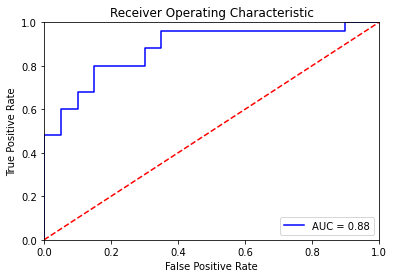

In [23]:
# Compute predicted probabilities on the test set
probs = bert_predict(ctbert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

In [25]:
val_loss, val_accuracy,y_pred= evaluate(ctbert_classifier, val_dataloader)

In [26]:
np_preds=[]
for i in y_pred:
    b=i.cpu().detach().numpy()
    np_preds=np.append(np_preds,b,axis=0)
    

In [27]:
np_preds=np_preds.astype(int)

In [28]:
class_names = ['fake', 'real']
print(classification_report(y_val, np_preds, target_names=class_names))

              precision    recall  f1-score   support

        fake       0.74      0.70      0.72        20
        real       0.77      0.80      0.78        25

   micro avg       0.76      0.76      0.76        45
   macro avg       0.75      0.75      0.75        45
weighted avg       0.75      0.76      0.75        45



In [29]:
y_val.size

45

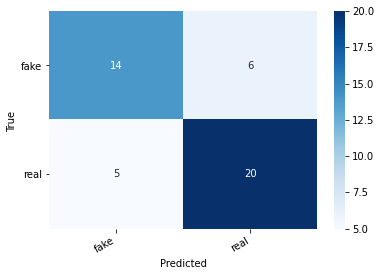

In [30]:
def show_confusion_matrix(confusion_matrix):
      hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
      hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
      hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
      plt.ylabel('True ')
      plt.xlabel('Predicted');
cm = confusion_matrix(y_val, np_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Random forest

In [41]:
preprocessed_tweets=[]
for i in X:
    preprocessed_tweets.append(text_preprocessing(i))

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(preprocessed_tweets)
# summarize
# encode document
vector = vectorizer.transform(preprocessed_tweets)
feature_names=vectorizer.get_feature_names()
# summarize encoded vector
f1=vector.toarray()


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [34]:
y_train

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,

In [45]:
class RandomForest:
    def __init__(self,RSEED=50,MAX_DEPTH=20,n_estimators=100):
        self.rseed=RSEED 
        self.max_depth=MAX_DEPTH
        self.n_estimators=n_estimators
    def train(self,X,y):
        model = RandomForestClassifier(n_estimators=self.n_estimators, 
                               bootstrap = True,
                               max_features = 'sqrt')
#         # Fit on training data
        indices = np.arange(len(X))
        train_idx, test_idx, y_train, y_test= train_test_split(indices, y,stratify = y, test_size=0.1, random_state=42)
        train_X = X[train_idx]
        test_X = X[test_idx]
        model=model.fit(train_X,y_train)

        return model,test_X, y_test,y_train,train_X,train_idx, test_idx

    def evaluate(self,model,test_X, y_test,y_train,train_X):
        """Compare machine learning model to baseline performance.
        Computes statistics and shows ROC curve."""
        results = {}
        
        print(f'Model Accuracy: {model.score(test_X, y_test)}')
        train_probs = model.predict_proba(train_X)[:, 1]
        probs = model.predict_proba(test_X)[:, 1]

        train_predictions = model.predict(train_X)
        predictions = model.predict(test_X)


        print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
        print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')
        


#         results['recall'] = recall_score(y_test, predictions, average="binary", pos_label='Fake')
#         results['precision'] = precision_score(y_test, predictions, average="binary", pos_label='Fake')
#         results['roc'] = roc_auc_score(y_test, probs)
#         print(results)
        return y_test,predictions

In [46]:
rf=RandomForest(RSEED=50,MAX_DEPTH=20,n_estimators=100)

In [47]:
clf,test_X, y_test,y_train,train_X,train_idx, test_idx=rf.train(f1,y)
y_test,predictions=rf.evaluate(clf,test_X, y_test,y_train,train_X)

Model Accuracy: 0.7857142857142857
Train ROC AUC Score: 0.999940880874963
Test ROC AUC  Score: 0.8764302059496567


In [48]:
class_names = ['fake', 'real']
print(classification_report(y_test, predictions, target_names=class_names))

              precision    recall  f1-score   support

        fake       0.92      0.58      0.71        19
        real       0.73      0.96      0.83        23

   micro avg       0.79      0.79      0.79        42
   macro avg       0.82      0.77      0.77        42
weighted avg       0.82      0.79      0.78        42



In [49]:
predictions

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

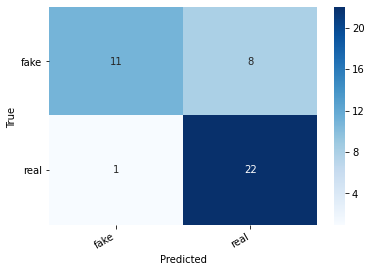

In [50]:
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)